## Importing all the modules required for this project

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline
import pandas as pd

Using TensorFlow backend.


## Reading  data

In [2]:
#Reading train data
train_df  = pd.read_csv('C:\\Users\\Shrinivas2448311\
\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\train_FD004.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

## Reading labels 

In [3]:
# reading ground truth data
truth_df = pd.read_csv('C:\\Users\\Shrinivas2448311\
\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\RUL_FD004.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [4]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


## Generating Remaining Useful Life

In [5]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


## Adding label to the data

#### If the Remaining Useful life of a particular engine cycle is 30 or less we label it as 1 indicating a Failure
#### So that maintainence can be planned beforehand.

In [6]:
# generate label columns for training data
w1 = 30

train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320,0
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319,0
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318,0
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317,0
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316,0


## MinMax normalization 

In [7]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,...,0.400540,0.0,0.288660,0.627907,1.0,0.015473,0.015881,320,0,0.000000
1,1,2,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,...,0.351346,0.0,0.608247,0.864693,1.0,0.477968,0.481487,319,0,0.001845
2,1,3,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,...,0.423787,0.0,0.278351,0.627907,1.0,0.010764,0.018932,318,0,0.003690
3,1,4,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,...,0.401716,0.0,0.268041,0.627907,1.0,0.012782,0.018724,317,0,0.005535
4,1,5,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,...,0.920536,0.0,0.030928,0.000000,0.0,0.130172,0.145560,316,0,0.007380


In [9]:
tr= train_df.drop('label1',axis=1)
y = train_df['label1']

## Over-Sampling using SMOTE

In [10]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling


sm = SMOTE(random_state=12, ratio = 1.0)
#X_train_sampled, Y_train_sampled = sm.fit_sample(X_train, Y_train)
X_train_sampled, Y_train_sampled = sm.fit_sample(tr, y)

C:\Users\Ashish2448311\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
df=pd.DataFrame(X_train_sampled)
df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21','RUL','cycle_norm']

In [12]:
unique, counts = np.unique(Y_train_sampled, return_counts=True)
dict(zip(unique, counts))

{0: 53530, 1: 53530}

In [13]:
label=pd.DataFrame(Y_train_sampled)
label.columns=['label1']
df['label1']=label

## window size of 30

In [14]:
# pick a  window size of 30 cycles
sequence_length = 30

## function to reshape features into (samples, time steps, features)

In [15]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


# generator for the sequences
seq_gen = (list(gen_sequence(df[df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())


seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape


# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(df[df['id']==id], sequence_length, ['label1']) 
             for id in df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(90075, 1)

## Splitting of data into 20% validation set and 80%training set

In [16]:
RANDOM_SEED=40
X_train, X_test, y_train, y_test = train_test_split(
        seq_array, label_array, test_size=0.2, random_state=RANDOM_SEED)#split the data into training and test (20%) set

## building the network

In [17]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()




model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [18]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


## Fitting the network

In [22]:
%%time
# fit the network

model.fit(X_train,y_train, epochs=10, batch_size=50,validation_data=(X_test,y_test), verbose=1,
        )

Train on 72060 samples, validate on 18015 samples
Epoch 1/10
72060/72060 [==============================] - 179s - loss: 0.1627 - acc: 0.9378 - val_loss: 0.1280 - val_acc: 0.9503
Epoch 2/10
72060/72060 [==============================] - 179s - loss: 0.1295 - acc: 0.9492 - val_loss: 0.1219 - val_acc: 0.9568
Epoch 3/10
72060/72060 [==============================] - 179s - loss: 0.1087 - acc: 0.9573 - val_loss: 0.0889 - val_acc: 0.9636
Epoch 4/10
72060/72060 [==============================] - 176s - loss: 0.0933 - acc: 0.9635 - val_loss: 0.1286 - val_acc: 0.9455
Epoch 5/10
72060/72060 [==============================] - 173s - loss: 0.0850 - acc: 0.9664 - val_loss: 0.1125 - val_acc: 0.9551
Epoch 6/10
72060/72060 [==============================] - 175s - loss: 0.0769 - acc: 0.9703 - val_loss: 0.0681 - val_acc: 0.9742
Epoch 7/10
72060/72060 [==============================] - 172s - loss: 0.0727 - acc: 0.9718 - val_loss: 0.0795 - val_acc: 0.9728
Epoch 8/10
72060/72060 [=======================

## Function for confusion matrix

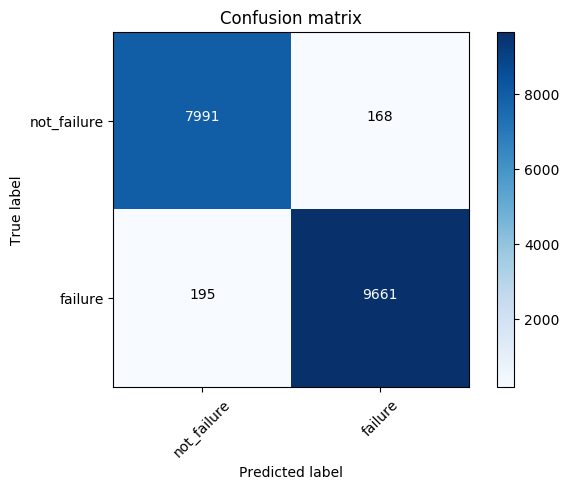

precision =  0.982907722047 
 recall =  0.980215097403


In [98]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['not_failure','failure']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')


plt.show()
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## type of learning rate vs val accuracy

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['time_based_learning(0.9660)', 'drop_based_learning(0.9609)', 'constant_learning(0.951)'],
            y=[0.9660, 0.9609, 0.951]
    )]
layout = dict(title = 'type of Learning rate vs val_accuracy',
              xaxis = dict(title = 'type of learning_rate'),
              yaxis = dict(title = 'val_Accuracy'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## Type of learning rate vs time

In [4]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['time_based_learning(25.40 min)', 'drop_based_learning(24.38 min)', 'constant_learning(30 min)'],
            y=[25.40, 24.38, 30]
    )]
layout = dict(title = 'type of Learning rate vs time',
              xaxis = dict(title = 'type of learning_rate'),
              yaxis = dict(title = 'time in min'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## val accuracy v batch size

In [2]:

import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=[50,100,200,400],
    y=[0.9799,0.9676,0.9618,0.9644],
    name='accurcy'
)

data = [trace1]
layout = go.Layout(
    title='val_accuracy vs batch_size',
    xaxis = dict(title = 'batch_size'),
    yaxis=dict(
        title='val_accuracy'
    )
        
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-axes-double')

# Length sequence vs val accuracy and time

In [1]:

import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=[0,30,50,75],
    y=[0,0.9629,0.9618,0.9638],
    name='accurcy'
)
trace2 = go.Scatter(
    x=[0,30,50,75],
    y=[0,23,34.85,42.26],
    name='time',
    yaxis='y2'
)
data = [trace1, trace2]
layout = go.Layout(
    title='length_sequence vs val_accuracy and time',
    xaxis = dict(title = 'length_sequence'),
    yaxis=dict(
        title='val_accuracy'
    ),
    yaxis2=dict(
        title='time in minutes',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-axes-double')


## SVM Results

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['val_accuracy(0.93)', 'precision_score(0.91)', 'recall(0.52)'],
            y=[0.93, 0.91, 0.52]
    )]
layout = dict(title = 'SVM results with 90% variance(2 components)',
              xaxis = dict(title = 'SVM')
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## Random forest

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['val_accuracy(0.959)', 'precision_score(0.924)', 'recall(0.748)'],
            y=[0.959, 0.924, 0.748]
    )]
layout = dict(title = 'Random forest results with 90% variance(2 components)',
              xaxis = dict(title = 'Random forest')
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## LSTM results

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['val_accuracy(0.93)', 'precision_score(0.8274)', 'recall( 0.825)'],
            y=[0.93, 0.8274, 0.825]
    )]
layout = dict(title = 'LSTM results ',
              xaxis = dict(title = 'LSTM')
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## Results of all the algorithms

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.931, 0.959, 0.9799],
    name='val_accuracy'
)
trace2 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.91,0.924,0.82],
    name='precision'
)
trace3 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.52, 0.748,0.825 ],
    name='recall'
)


data = [trace1, trace2,trace3 ]

layout = go.Layout(
    barmode='group',
    title='Results of all the algorithms',
    xaxis = dict(title = 'Algorithms')      
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-axes-double')

## Results of all algorithm after sampling


In [9]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.95, 0.949, 0.9732],
    name='val_accuracy'
)
trace2 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.76,0.79,0.984],
    name='precision'
)
trace3 = go.Bar(
    x=['SVM(90%_variance)', 'random forest(90%_variance)', 'LSTM'],
    y=[0.90, 0.81,0.974 ],
    name='recall'
)


data = [trace1, trace2,trace3 ]

layout = go.Layout(
    barmode='group',
    title='Results of all the algorithms after oversampling',
    xaxis = dict(title = 'Algorithms')      
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='multiple-axes-double')

#### Achitecture and Parameters of the Final LSTM Model

### Insights

#### Using variable learning rate we can improve the computational time without compromising much on the accuracy.
